## Dirichlet Process Mixture Models

In purpose to find main types of personalities in our Big five psychological test data set we used Dirichlet Process Mixture Models, that solves this clustering problem. Dirichlet Process Mixture Models is example of Bayesian non parametric model.

Bayesian non parametric models are models where the number of parameters grow freely with the amount of data provided. Big advantage of DPMM, in comparison to other clustering models, is that there is no need to pass desired number of cluster — model determinate it itself. This is very useful in case of our task, where we don't know how many different personalities can hide in data set. 

## The Dirichlet Process

Dirichlet's processes are a family of probability distributions over discrete probability distributions. Dirichlet's process (DP) is specified by some base probability distribution \\(G_0 : \Omega \rightarrow \mathbb{R}\\) and a positive, real, scaling parameter commonly denoted as \\(\alpha\\). A sample G from a Dirichlet process is itself a distribution over Ω. For any disjoint partition \\(\Omega_1, ..., \Omega_k\\) of \\(\Omega\\), and any sample \\(G \sim DP(G_0, \alpha)\\), we have:
\begin{equation}
(G(\Omega_1), ..., G(\Omega_k)) \sim \text{Dir}(\alpha G_0(\Omega_1), ..., \alpha G_0(\Omega_k))
\end{equation}
This is taking a discrete partition of our sample space \\(\Omega\\) and subsequently constructing a discrete distribution over it, using the base distribution \\(G_0\\). Now, as we are familiar with Dirichlet Process, we can move to similar term — Chinese Restaurant Process.

## The Chinese Restaurant Process

Imagine a restaurant with infinite tables, that accepts customers one at a time. The n-th customer chooses their seat according to the following probabilities:

 - With probability \\(\frac{n_t}{\alpha + n — 1}\\), sit at table t, where nt is the number of people at table t
 - With probability \\(\frac{\alpha}{\alpha + n — 1}\\), sit at an empty table

If we associate each table with draw from distribution \\(G_0\\) and unnormalized probability mass \\(n_t\\) to that draw, the resulting distribution is equivalent to draw from Dirichlet process. We can use this process to define our non parametric mixture model. For each row of data (customer), we will assign it to a cluster (table), given by categorical distribution parameters, which were drown from categorical conjugate — Dirichlet distribution (\\(G_0\\)). This process is overall describe of what we are doing. To be more particular, in implementation is used Stick-Breaking Method.

## The Stick-Breaking Method

This process, used for clasterisation with DPMM, proceeds as follows:
   - Draw \\(\beta_i \sim \text{Beta}(1, \alpha)\\) for \\(i \in \mathbb{N}\\)

   - Draw parameters for i-th distribution \\(\theta_i \sim G_0\\) for \\(i \in \mathbb{N}\\) 

   - Construct the mixture weights \\(\pi\\) by taking \\(\pi_i(\beta_{1:\infty}) = \beta_i \prod_{j<i} (1-\beta_j)\\)

   - For each observation \\(n \in \{1, ..., N\}\\), draw "table" \\(z_n \sim \pi(\beta_{1:\infty})\\), and then draw \\(x_n \sim f(\theta_{z_n})\\)

In theory, there may be infinite amount of tables and corresponding to them weights/parameters, but in implementation we guess value T, which constraints upper limit of possible clusters. In our task, we want to find main types of personalities. In particular, we are interested in finding parameters of each categorical distributions, which are creating these clusters (personalities). Parameters of each categorical distribution are five probabilities of every possible answer for question (1,2,3,4,5) for all 50 questions from the test. As prior of categorical distribution parameters, we use it's conjugate — Dirichlet distribution.

\begin{equation}
z_n \sim \pi(\beta_{1:\infty}), \ \theta_{z_n} \sim Dirichlet(\tau), \ \theta_{z_n} = [p_{grade1},p_{grade_2},p_{grade_3},p_{grade_4},p_{grade_5}]^{50}, \\ x_n \sim Categorical(\theta_{z_n}),\ x_n \in {\{grade_1,grade_2,grade_3,grade_4,grade_5\}}^{50}
\end{equation}

inspired by: https://pyro.ai/examples/dirichlet_process_mixture.html

In [1]:
import torch
from torch.distributions import constraints
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from common import N_COUNTIRES, load_joint, empty_df, positive_correlation, QUESTIONS
from sklearn.preprocessing import OrdinalEncoder
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
import torch.distributions.constraints as const
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import numpy as np
import sys
import itertools
from sklearn.metrics import *
import seaborn as sns
import pandas as pd
from IPython.display import display
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
np.set_printoptions(threshold=sys.maxsize)

In [2]:
data = load_joint(10_00).dropna(axis=0)
countries_encoder = OrdinalEncoder()
countries = countries_encoder.fit_transform(data['country'].values.reshape(-1, 1)).reshape(-1)

data10000 = load_joint(10_000).dropna(axis=0)
countries10000_encoder = OrdinalEncoder()
countries10000 = countries10000_encoder.fit_transform(data10000['country'].values.reshape(-1, 1)).reshape(-1)

data100000 = load_joint(10_0000).dropna(axis=0)
countries100000_encoder = OrdinalEncoder()
countries100000 = countries100000_encoder.fit_transform(data100000['country'].values.reshape(-1, 1)).reshape(-1)

data1000000 = load_joint(10_00000).dropna(axis=0)
countries1000000_encoder = OrdinalEncoder()
countries1000000 = countries1000000_encoder.fit_transform(data1000000['country'].values.reshape(-1, 1)).reshape(-1)

In [3]:
answers = data.drop(['country'], axis=1).values.reshape(-1)-1
answers = torch.tensor(np.clip(answers, 0.0, 4.0).reshape(-1, 50))

answers10000 = data10000.drop(['country'], axis=1).values.reshape(-1)-1
answers10000 = torch.tensor(np.clip(answers10000, 0.0, 4.0).reshape(-1, 50))

answers100000 = data100000.drop(['country'], axis=1).values.reshape(-1)-1
answers100000 = torch.tensor(np.clip(answers100000, 0.0, 4.0).reshape(-1, 50))

answers1000000 = data1000000.drop(['country'], axis=1).values.reshape(-1)-1
answers1000000 = torch.tensor(np.clip(answers1000000, 0.0, 4.0).reshape(-1, 50))

In [13]:
N = answers10000.shape[0]
question_ammount = 50
pyro.distributions.enable_validation(True)
pyro.enable_validation(True)

def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

#@config_enumerate
def model(data):
    with pyro.plate("beta_plate", T-1):
        beta = pyro.sample("beta", dist.Beta(1, alpha))

    with pyro.plate("qustion_plate", question_ammount):
        with pyro.plate("prob_plate", T):
            answer_probs = pyro.sample("probs", dist.Dirichlet(1/5 * torch.ones(5), validate_args=False))

    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Categorical(mix_weights(beta)))
        pyro.sample("obs", dist.Categorical(answer_probs[z]).to_event(1), obs=data)
        
        
def guide(data):
    kappa = pyro.param('kappa', lambda: dist.Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: 1/5 * torch.ones(T,question_ammount, 5), constraint=constraints.simplex)
    phi = pyro.param('phi', lambda: 1/T * torch.ones(N,T), constraint=constraints.simplex)
    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", dist.Beta(torch.ones(T-1), kappa))

    with pyro.plate("qustion_plate", question_ammount):
        with pyro.plate("prob_plate", T):
            answer_probs = pyro.sample("probs", dist.Dirichlet(tau))

    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Categorical(phi))
        
def train(num_iterations, lr, training_data):
    pyro.clear_param_store()
    optim = Adam({"lr": lr})
    #global_guide = AutoDelta(poutine.block(model, expose=['beta','probs']))
    svi = SVI(model, guide, optim, loss=Trace_ELBO())
    losses = []
    for j in tqdm(range(num_iterations)):
        loss = svi.step(training_data)
        losses.append(loss)
    return losses


In [5]:
def truncate(alpha, probs, weights):
    threshold = 1 / 100.
    print(alpha)
    print(threshold)
    print(weights)
    print(weights.sum())
    true_probs = probs[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_probs, true_weights

In [33]:
T = 10
lr = 0.05
alpha = 0.1
n_iter=500

losses = train(n_iter, lr, answers10000)

answer_probs, cluster_weights = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

#for i in range(len(answer_probs)):
#    aprox_personality[i] = dist.Categorical(answer_probs[i]).sample_n(10000).float().mean(0)+1

100%|██████████| 500/500 [01:44<00:00,  4.79it/s]

0.1
0.01
tensor([0.1036, 0.1014, 0.1030, 0.0992, 0.0982, 0.0988, 0.0979, 0.0975, 0.0983,
        0.1019])
tensor(1.0000)


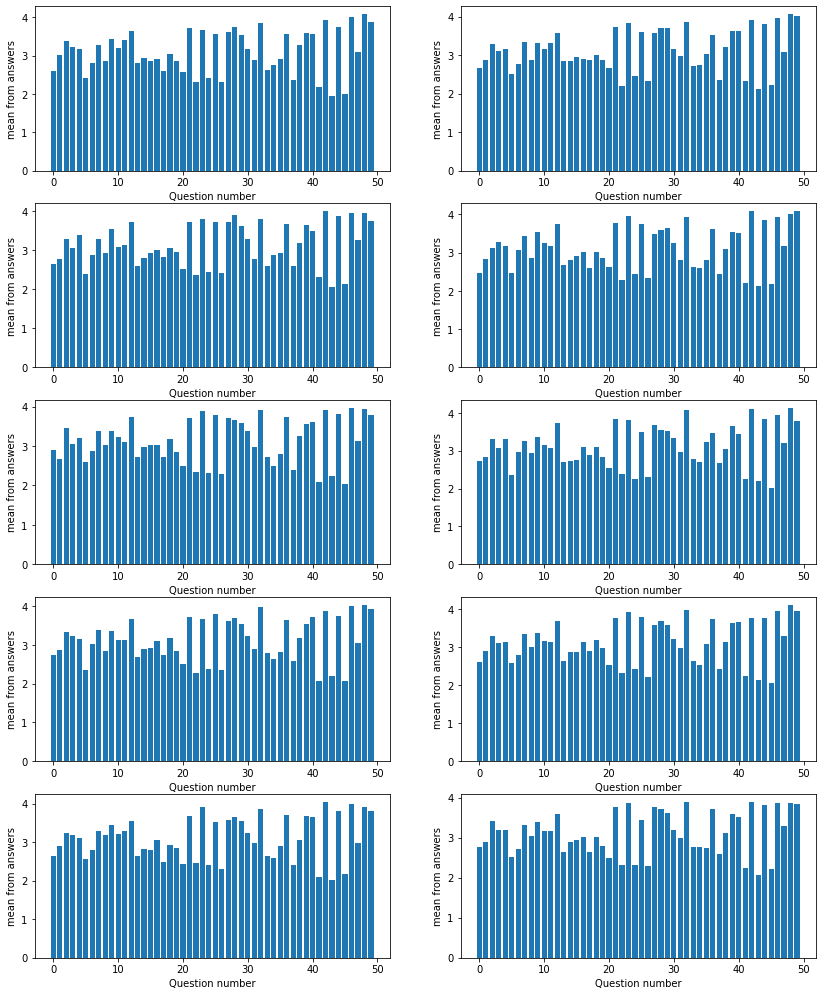

In [34]:

aprox_personality = torch.zeros(len(answer_probs),len(answer_probs[0]))

#Calculeting expected value for each question in each cluster
for i in range(len(answer_probs)):
    aprox_personality[i] = (answer_probs[i]@(torch.tensor([1.,2.,3.,4.,5.])))

fig, ax_all = plt.subplots(math.ceil(len(aprox_personality)/2), 2, figsize=(14,3.5*math.ceil(len(aprox_personality)/2)))
for i, col in enumerate(aprox_personality):
    # Set up the plot
    if isinstance(ax_all, np.ndarray):
        ax = ax_all[math.floor(i/2),i%2]
    else:
        ax = ax_all[i%2]
    # Draw the plot
    ax.bar(np.arange(len(aprox_personality[i])), aprox_personality[i].numpy())

    ## Title and labels
    ax.set_xlabel("Question number", size = 10)
    ax.set_ylabel("mean from answers", size= 10)

In [35]:
X, Y = prepere_clusters_sample(10000)

print(silhouette_score(X, Y, sample_size=500))
print(davies_bouldin_score(X, Y))

-0.015222406
22.683587006870333


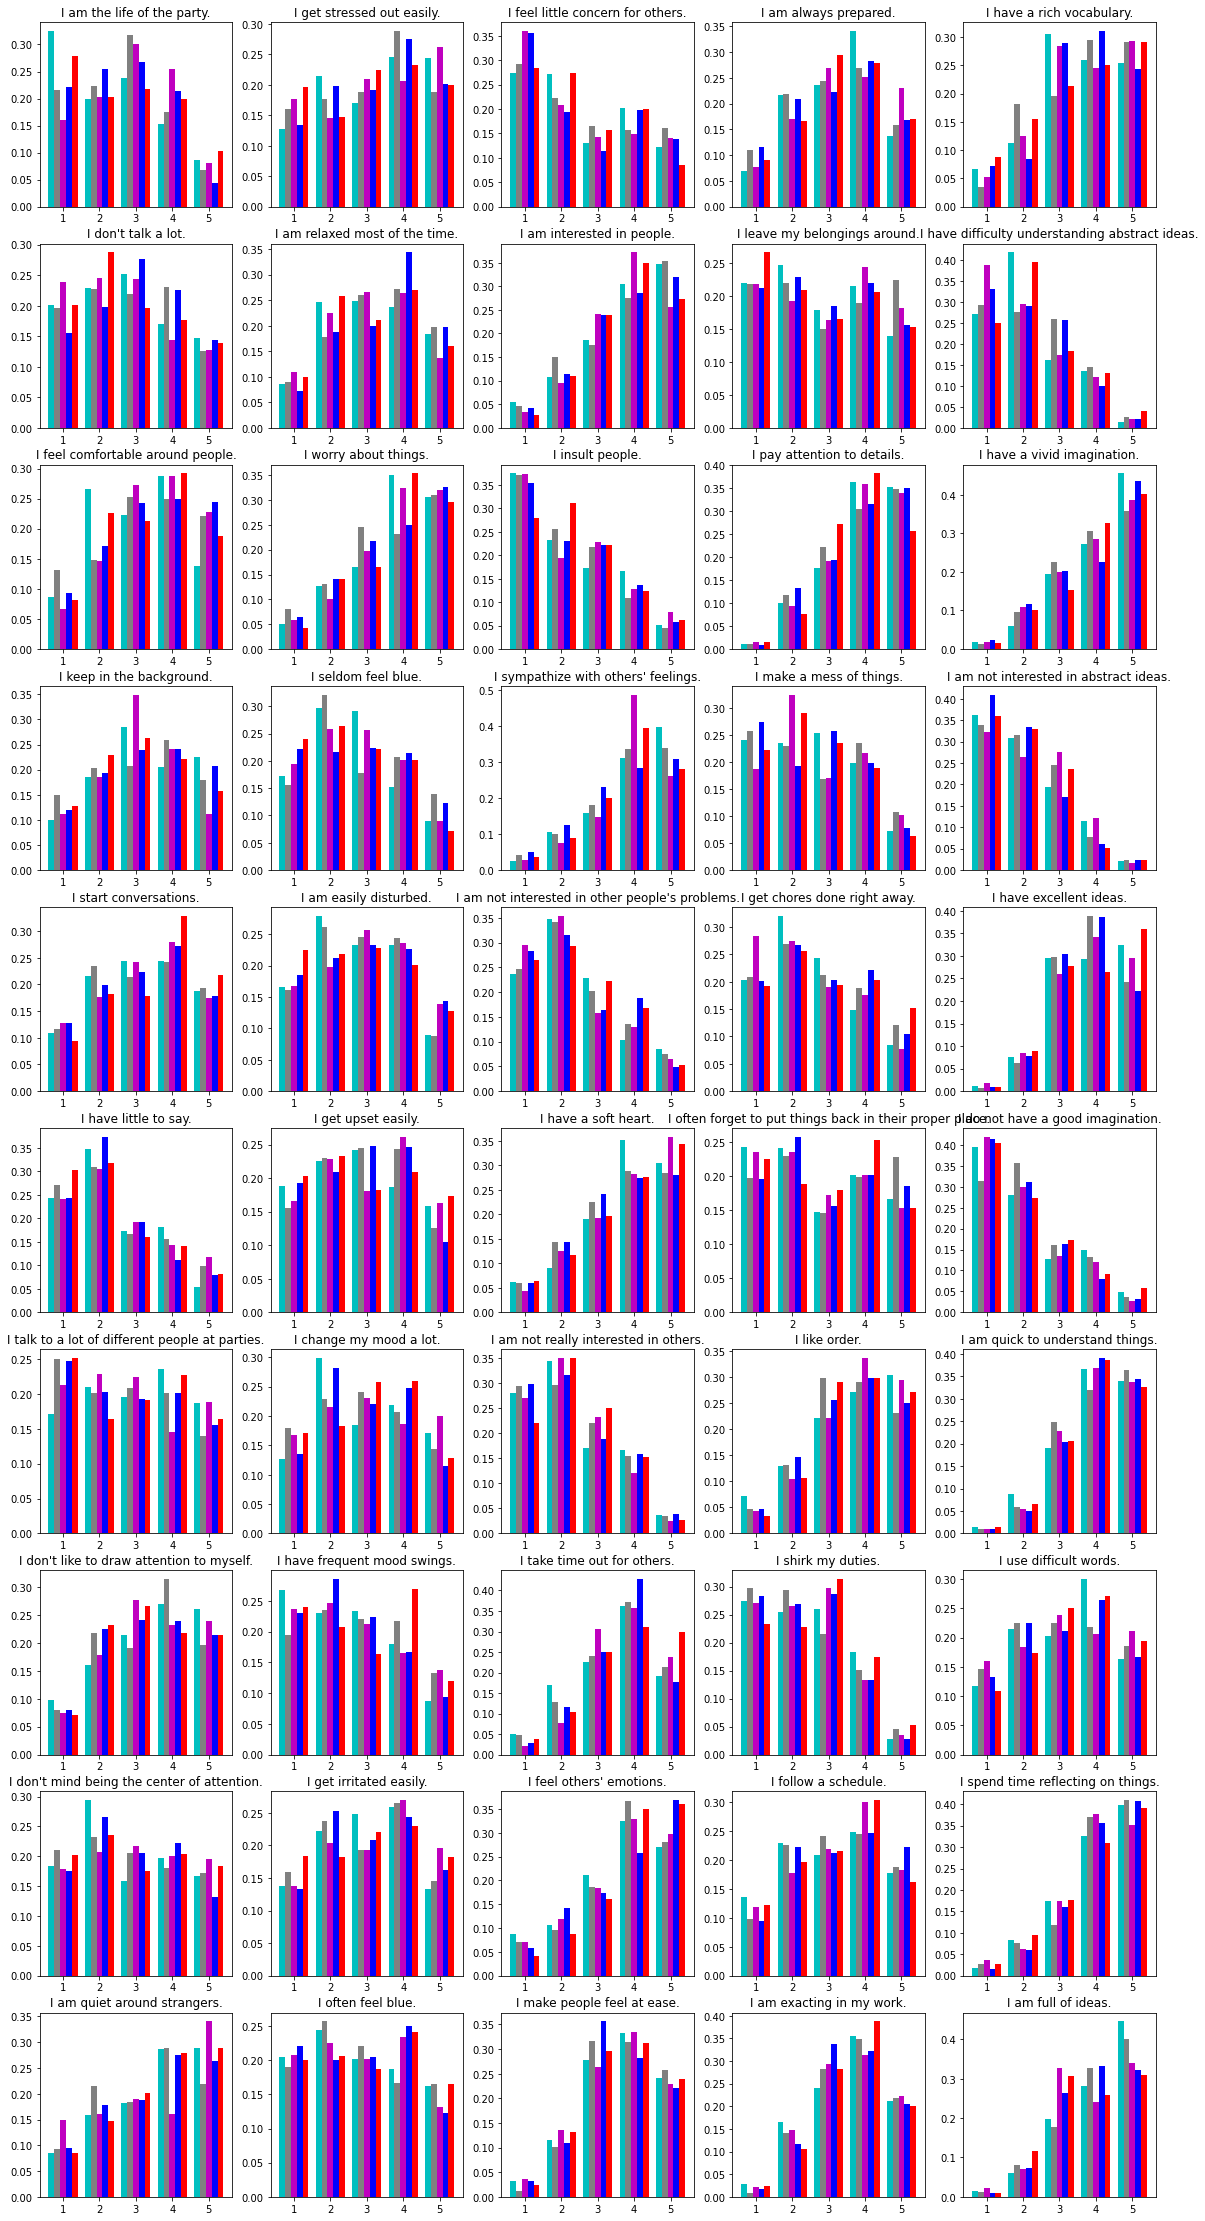

In [36]:
figs, axs = plt.subplots(10, 5, figsize=(5 * 4, 10 * 4))

import collections
for i in range(5):
    for j in range(10):
        question_nr = i * 10 + j
        question = list(QUESTIONS.values())[question_nr]
        number_cluster = len(answer_probs)

        columns=np.asarray([1,2,3,4,5])
        col_width = 0.8/5
        axs[j][i].bar(columns + col_width, answer_probs[0,question_nr], color='b', width=col_width, align='center')
        axs[j][i].bar(columns - col_width, answer_probs[1,question_nr], color='gray', width=col_width, align='center')
        axs[j][i].bar(columns + 2*col_width, answer_probs[2,question_nr], color='r', width=col_width, align='center')
        axs[j][i].bar(columns - 2*col_width, answer_probs[3,question_nr], color='c', width=col_width, align='center')
        axs[j][i].bar(columns, answer_probs[4,question_nr], color='m', width=col_width, align='center')
        axs[j, i].set_title(question)

-0.019175777
23.111238297312717


/home/janek/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


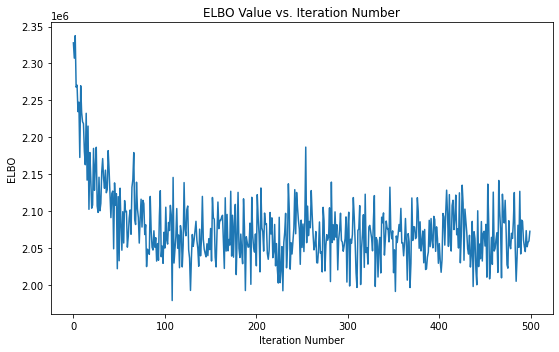

In [37]:
X, Y = prepere_clusters_sample(10000)
print(silhouette_score(X, Y, sample_size=500))
print(davies_bouldin_score(X, Y))
elbo_plot = plt.figure(figsize=(15, 5))

elbo_ax = elbo_plot.add_subplot(1, 2, 1)
elbo_ax.set_title("ELBO Value vs. Iteration Number")
elbo_ax.set_ylabel("ELBO")
elbo_ax.set_xlabel("Iteration Number")
elbo_ax.plot(np.arange(n_iter), losses)

elbo_plot.tight_layout()
elbo_plot.show()

In [6]:
def prepere_clusters_sample(how_many_samples):
    how_big_set = len(answer_probs)*how_many_samples
    aprox_personality = torch.zeros(how_big_set,len(answer_probs[0]))
    personality_targets = torch.zeros(how_big_set)
    #aprox_personality = dist.Categorical(answer_probs).sample_n(how_many_samples).float()
    for i in range(0,how_big_set,how_many_samples):
        cluster_number = int(i/how_many_samples)
        aprox_personality[i:i+how_many_samples] = dist.Categorical(answer_probs[cluster_number]).sample((how_many_samples,)).float()
        personality_targets[i:i+how_many_samples] = cluster_number
    return aprox_personality, personality_targets

In [10]:
how_many_samples=10000
n_iter = 200

alphas = [0.001, 0.1, 10, 100]
t_values = [5, 50, 100]
l_rate_values = [0.1, 0.01, 0.05, 0.001, 0.0001]
params_tuples = list(itertools.product(alphas, t_values))
print(params_tuples)
losses_array = []
dbi_array = []
silhouette_array = []
for val, t_value in params_tuples:
        alpha = val
        #alpha = 0.15
        T = t_value
        lr = 0.05
        losses_array.append(train(n_iter, lr, answers)[-1])
        #print(torch.mean(pyro.param("phi").detach(), dim=0))
        answer_probs, cluster_weights = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))
        print(cluster_weights)
        X, Y = prepere_clusters_sample(how_many_samples)

        silhouette_array.append(silhouette_score(X, Y, sample_size=500))
        dbi_array.append(davies_bouldin_score(X, Y))

  1%|          | 2/200 [00:00<00:11, 16.86it/s]

[(0.001, 5), (0.001, 50), (0.001, 100), (0.1, 5), (0.1, 50), (0.1, 100), (10, 5), (10, 50), (10, 100), (100, 5), (100, 50), (100, 100)]


100%|██████████| 200/200 [00:06<00:00, 32.17it/s]


0.001
0.01
tensor([0.2023, 0.2061, 0.1978, 0.1914, 0.2024])
tensor(1.0000)
tensor([0.2023, 0.2061, 0.1978, 0.1914, 0.2024])


100%|██████████| 200/200 [00:13<00:00, 14.59it/s]


0.001
0.01
tensor([0.0178, 0.0204, 0.0248, 0.0218, 0.0215, 0.0166, 0.0222, 0.0208, 0.0179,
        0.0200, 0.0193, 0.0216, 0.0196, 0.0204, 0.0181, 0.0177, 0.0208, 0.0202,
        0.0207, 0.0202, 0.0208, 0.0198, 0.0192, 0.0200, 0.0204, 0.0206, 0.0220,
        0.0187, 0.0178, 0.0189, 0.0177, 0.0195, 0.0211, 0.0188, 0.0215, 0.0206,
        0.0226, 0.0224, 0.0210, 0.0204, 0.0205, 0.0219, 0.0183, 0.0171, 0.0218,
        0.0191, 0.0195, 0.0202, 0.0174, 0.0181])
tensor(1.0000)
tensor([0.0178, 0.0204, 0.0248, 0.0218, 0.0215, 0.0166, 0.0222, 0.0208, 0.0179,
        0.0200, 0.0193, 0.0216, 0.0196, 0.0204, 0.0181, 0.0177, 0.0208, 0.0202,
        0.0207, 0.0202, 0.0208, 0.0198, 0.0192, 0.0200, 0.0204, 0.0206, 0.0220,
        0.0187, 0.0178, 0.0189, 0.0177, 0.0195, 0.0211, 0.0188, 0.0215, 0.0206,
        0.0226, 0.0224, 0.0210, 0.0204, 0.0205, 0.0219, 0.0183, 0.0171, 0.0218,
        0.0191, 0.0195, 0.0202, 0.0174, 0.0181])


100%|██████████| 200/200 [00:11<00:00, 17.14it/s]


0.001
0.01
tensor([0.0101, 0.0097, 0.0110, 0.0109, 0.0114, 0.0096, 0.0110, 0.0099, 0.0088,
        0.0106, 0.0106, 0.0080, 0.0118, 0.0078, 0.0095, 0.0099, 0.0129, 0.0073,
        0.0107, 0.0111, 0.0095, 0.0083, 0.0089, 0.0102, 0.0088, 0.0088, 0.0110,
        0.0093, 0.0072, 0.0122, 0.0093, 0.0069, 0.0127, 0.0086, 0.0100, 0.0083,
        0.0089, 0.0117, 0.0078, 0.0107, 0.0108, 0.0090, 0.0112, 0.0125, 0.0109,
        0.0099, 0.0111, 0.0108, 0.0106, 0.0101, 0.0125, 0.0104, 0.0077, 0.0094,
        0.0106, 0.0098, 0.0109, 0.0102, 0.0104, 0.0084, 0.0094, 0.0093, 0.0110,
        0.0121, 0.0092, 0.0102, 0.0082, 0.0099, 0.0093, 0.0121, 0.0088, 0.0083,
        0.0087, 0.0084, 0.0088, 0.0107, 0.0079, 0.0082, 0.0139, 0.0109, 0.0106,
        0.0107, 0.0110, 0.0088, 0.0110, 0.0099, 0.0111, 0.0113, 0.0105, 0.0086,
        0.0090, 0.0106, 0.0091, 0.0113, 0.0103, 0.0101, 0.0108, 0.0088, 0.0131,
        0.0084])
tensor(1.0000)
tensor([0.0176, 0.0191, 0.0188, 0.0197, 0.0190, 0.0184, 0.0184, 0.0205, 0.022

100%|██████████| 200/200 [00:06<00:00, 31.56it/s]


0.1
0.01
tensor([0.1926, 0.2010, 0.2053, 0.2031, 0.1980])
tensor(1.0000)
tensor([0.1926, 0.2010, 0.2053, 0.2031, 0.1980])


100%|██████████| 200/200 [00:13<00:00, 14.49it/s]


0.1
0.01
tensor([0.0211, 0.0183, 0.0245, 0.0186, 0.0180, 0.0214, 0.0196, 0.0212, 0.0201,
        0.0200, 0.0195, 0.0198, 0.0216, 0.0175, 0.0219, 0.0200, 0.0184, 0.0190,
        0.0209, 0.0196, 0.0209, 0.0209, 0.0202, 0.0218, 0.0199, 0.0196, 0.0203,
        0.0207, 0.0217, 0.0201, 0.0202, 0.0182, 0.0229, 0.0206, 0.0191, 0.0193,
        0.0180, 0.0207, 0.0201, 0.0202, 0.0187, 0.0167, 0.0216, 0.0213, 0.0186,
        0.0225, 0.0205, 0.0187, 0.0164, 0.0184])
tensor(1.0000)
tensor([0.0211, 0.0183, 0.0245, 0.0186, 0.0180, 0.0214, 0.0196, 0.0212, 0.0201,
        0.0200, 0.0195, 0.0198, 0.0216, 0.0175, 0.0219, 0.0200, 0.0184, 0.0190,
        0.0209, 0.0196, 0.0209, 0.0209, 0.0202, 0.0218, 0.0199, 0.0196, 0.0203,
        0.0207, 0.0217, 0.0201, 0.0202, 0.0182, 0.0229, 0.0206, 0.0191, 0.0193,
        0.0180, 0.0207, 0.0201, 0.0202, 0.0187, 0.0167, 0.0216, 0.0213, 0.0186,
        0.0225, 0.0205, 0.0187, 0.0164, 0.0184])


100%|██████████| 200/200 [00:11<00:00, 16.80it/s]


0.1
0.01
tensor([0.0109, 0.0100, 0.0107, 0.0114, 0.0115, 0.0103, 0.0103, 0.0090, 0.0104,
        0.0093, 0.0095, 0.0103, 0.0097, 0.0114, 0.0102, 0.0090, 0.0104, 0.0111,
        0.0103, 0.0121, 0.0117, 0.0109, 0.0093, 0.0091, 0.0090, 0.0097, 0.0103,
        0.0117, 0.0086, 0.0082, 0.0099, 0.0088, 0.0107, 0.0099, 0.0085, 0.0097,
        0.0086, 0.0082, 0.0093, 0.0112, 0.0103, 0.0082, 0.0084, 0.0113, 0.0080,
        0.0103, 0.0088, 0.0115, 0.0102, 0.0088, 0.0117, 0.0069, 0.0114, 0.0091,
        0.0121, 0.0113, 0.0079, 0.0100, 0.0102, 0.0105, 0.0107, 0.0098, 0.0136,
        0.0107, 0.0091, 0.0140, 0.0109, 0.0079, 0.0105, 0.0102, 0.0102, 0.0093,
        0.0106, 0.0089, 0.0062, 0.0100, 0.0090, 0.0091, 0.0115, 0.0095, 0.0116,
        0.0112, 0.0108, 0.0108, 0.0082, 0.0101, 0.0103, 0.0126, 0.0109, 0.0098,
        0.0110, 0.0081, 0.0101, 0.0095, 0.0087, 0.0082, 0.0095, 0.0110, 0.0078,
        0.0100])
tensor(1.)
tensor([0.0182, 0.0177, 0.0189, 0.0192, 0.0171, 0.0172, 0.0174, 0.0170, 0.0190,
   

100%|██████████| 200/200 [00:06<00:00, 32.26it/s]


10
0.01
tensor([0.1954, 0.1975, 0.1978, 0.2040, 0.2054])
tensor(1.)
tensor([0.1954, 0.1975, 0.1978, 0.2040, 0.2054])


100%|██████████| 200/200 [00:15<00:00, 13.11it/s]


10
0.01
tensor([0.0197, 0.0187, 0.0191, 0.0201, 0.0210, 0.0206, 0.0198, 0.0183, 0.0221,
        0.0202, 0.0169, 0.0202, 0.0224, 0.0189, 0.0219, 0.0217, 0.0203, 0.0197,
        0.0250, 0.0249, 0.0227, 0.0180, 0.0186, 0.0163, 0.0200, 0.0176, 0.0174,
        0.0228, 0.0215, 0.0189, 0.0205, 0.0212, 0.0186, 0.0195, 0.0185, 0.0199,
        0.0198, 0.0207, 0.0215, 0.0169, 0.0193, 0.0204, 0.0216, 0.0165, 0.0253,
        0.0197, 0.0177, 0.0193, 0.0204, 0.0174])
tensor(1.0000)
tensor([0.0197, 0.0187, 0.0191, 0.0201, 0.0210, 0.0206, 0.0198, 0.0183, 0.0221,
        0.0202, 0.0169, 0.0202, 0.0224, 0.0189, 0.0219, 0.0217, 0.0203, 0.0197,
        0.0250, 0.0249, 0.0227, 0.0180, 0.0186, 0.0163, 0.0200, 0.0176, 0.0174,
        0.0228, 0.0215, 0.0189, 0.0205, 0.0212, 0.0186, 0.0195, 0.0185, 0.0199,
        0.0198, 0.0207, 0.0215, 0.0169, 0.0193, 0.0204, 0.0216, 0.0165, 0.0253,
        0.0197, 0.0177, 0.0193, 0.0204, 0.0174])


100%|██████████| 200/200 [00:11<00:00, 16.75it/s]


10
0.01
tensor([0.0087, 0.0079, 0.0105, 0.0103, 0.0122, 0.0071, 0.0108, 0.0094, 0.0109,
        0.0086, 0.0084, 0.0109, 0.0112, 0.0111, 0.0086, 0.0114, 0.0115, 0.0071,
        0.0102, 0.0077, 0.0087, 0.0106, 0.0086, 0.0095, 0.0083, 0.0077, 0.0126,
        0.0106, 0.0121, 0.0099, 0.0118, 0.0110, 0.0113, 0.0116, 0.0131, 0.0116,
        0.0082, 0.0121, 0.0099, 0.0095, 0.0116, 0.0087, 0.0092, 0.0108, 0.0079,
        0.0086, 0.0083, 0.0099, 0.0101, 0.0093, 0.0064, 0.0107, 0.0097, 0.0132,
        0.0139, 0.0080, 0.0090, 0.0092, 0.0110, 0.0096, 0.0095, 0.0106, 0.0110,
        0.0107, 0.0100, 0.0099, 0.0096, 0.0098, 0.0087, 0.0094, 0.0096, 0.0118,
        0.0094, 0.0123, 0.0101, 0.0090, 0.0097, 0.0084, 0.0093, 0.0104, 0.0097,
        0.0099, 0.0111, 0.0094, 0.0108, 0.0122, 0.0124, 0.0084, 0.0099, 0.0099,
        0.0112, 0.0130, 0.0092, 0.0087, 0.0112, 0.0115, 0.0094, 0.0081, 0.0079,
        0.0085])
tensor(1.0000)
tensor([0.0209, 0.0205, 0.0244, 0.0215, 0.0217, 0.0217, 0.0224, 0.0222, 0.0227,


100%|██████████| 200/200 [00:06<00:00, 33.32it/s]


100
0.01
tensor([0.2077, 0.2008, 0.2000, 0.1931, 0.1985])
tensor(1.0000)
tensor([0.2077, 0.2008, 0.2000, 0.1931, 0.1985])


100%|██████████| 200/200 [00:14<00:00, 13.39it/s]


100
0.01
tensor([0.0200, 0.0208, 0.0191, 0.0241, 0.0200, 0.0174, 0.0196, 0.0214, 0.0202,
        0.0208, 0.0214, 0.0216, 0.0191, 0.0153, 0.0199, 0.0187, 0.0222, 0.0181,
        0.0177, 0.0199, 0.0222, 0.0200, 0.0191, 0.0213, 0.0182, 0.0227, 0.0201,
        0.0204, 0.0202, 0.0225, 0.0212, 0.0174, 0.0180, 0.0197, 0.0204, 0.0198,
        0.0209, 0.0198, 0.0185, 0.0211, 0.0202, 0.0230, 0.0187, 0.0175, 0.0209,
        0.0183, 0.0213, 0.0202, 0.0183, 0.0209])
tensor(1.0000)
tensor([0.0200, 0.0208, 0.0191, 0.0241, 0.0200, 0.0174, 0.0196, 0.0214, 0.0202,
        0.0208, 0.0214, 0.0216, 0.0191, 0.0153, 0.0199, 0.0187, 0.0222, 0.0181,
        0.0177, 0.0199, 0.0222, 0.0200, 0.0191, 0.0213, 0.0182, 0.0227, 0.0201,
        0.0204, 0.0202, 0.0225, 0.0212, 0.0174, 0.0180, 0.0197, 0.0204, 0.0198,
        0.0209, 0.0198, 0.0185, 0.0211, 0.0202, 0.0230, 0.0187, 0.0175, 0.0209,
        0.0183, 0.0213, 0.0202, 0.0183, 0.0209])


100%|██████████| 200/200 [00:11<00:00, 16.78it/s]


100
0.01
tensor([0.0103, 0.0102, 0.0111, 0.0089, 0.0091, 0.0100, 0.0081, 0.0079, 0.0108,
        0.0122, 0.0106, 0.0106, 0.0095, 0.0097, 0.0096, 0.0088, 0.0096, 0.0117,
        0.0106, 0.0111, 0.0094, 0.0096, 0.0120, 0.0099, 0.0093, 0.0108, 0.0089,
        0.0076, 0.0083, 0.0081, 0.0092, 0.0122, 0.0092, 0.0103, 0.0099, 0.0093,
        0.0089, 0.0100, 0.0099, 0.0100, 0.0085, 0.0101, 0.0106, 0.0098, 0.0087,
        0.0080, 0.0115, 0.0116, 0.0102, 0.0095, 0.0107, 0.0105, 0.0118, 0.0084,
        0.0116, 0.0114, 0.0111, 0.0110, 0.0113, 0.0088, 0.0095, 0.0105, 0.0106,
        0.0104, 0.0103, 0.0099, 0.0084, 0.0095, 0.0091, 0.0088, 0.0099, 0.0112,
        0.0109, 0.0110, 0.0091, 0.0102, 0.0086, 0.0106, 0.0091, 0.0106, 0.0116,
        0.0107, 0.0103, 0.0095, 0.0096, 0.0092, 0.0083, 0.0079, 0.0114, 0.0111,
        0.0112, 0.0090, 0.0096, 0.0093, 0.0092, 0.0128, 0.0082, 0.0114, 0.0120,
        0.0109])
tensor(1.)
tensor([0.0192, 0.0189, 0.0207, 0.0201, 0.0227, 0.0198, 0.0197, 0.0218, 0.0197,
   

In [11]:
print(list(map(str,params_tuples)))

['(0.001, 5)', '(0.001, 50)', '(0.001, 100)', '(0.1, 5)', '(0.1, 50)', '(0.1, 100)', '(10, 5)', '(10, 50)', '(10, 100)', '(100, 5)', '(100, 50)', '(100, 100)']


Text(0, 0.5, 'losses')

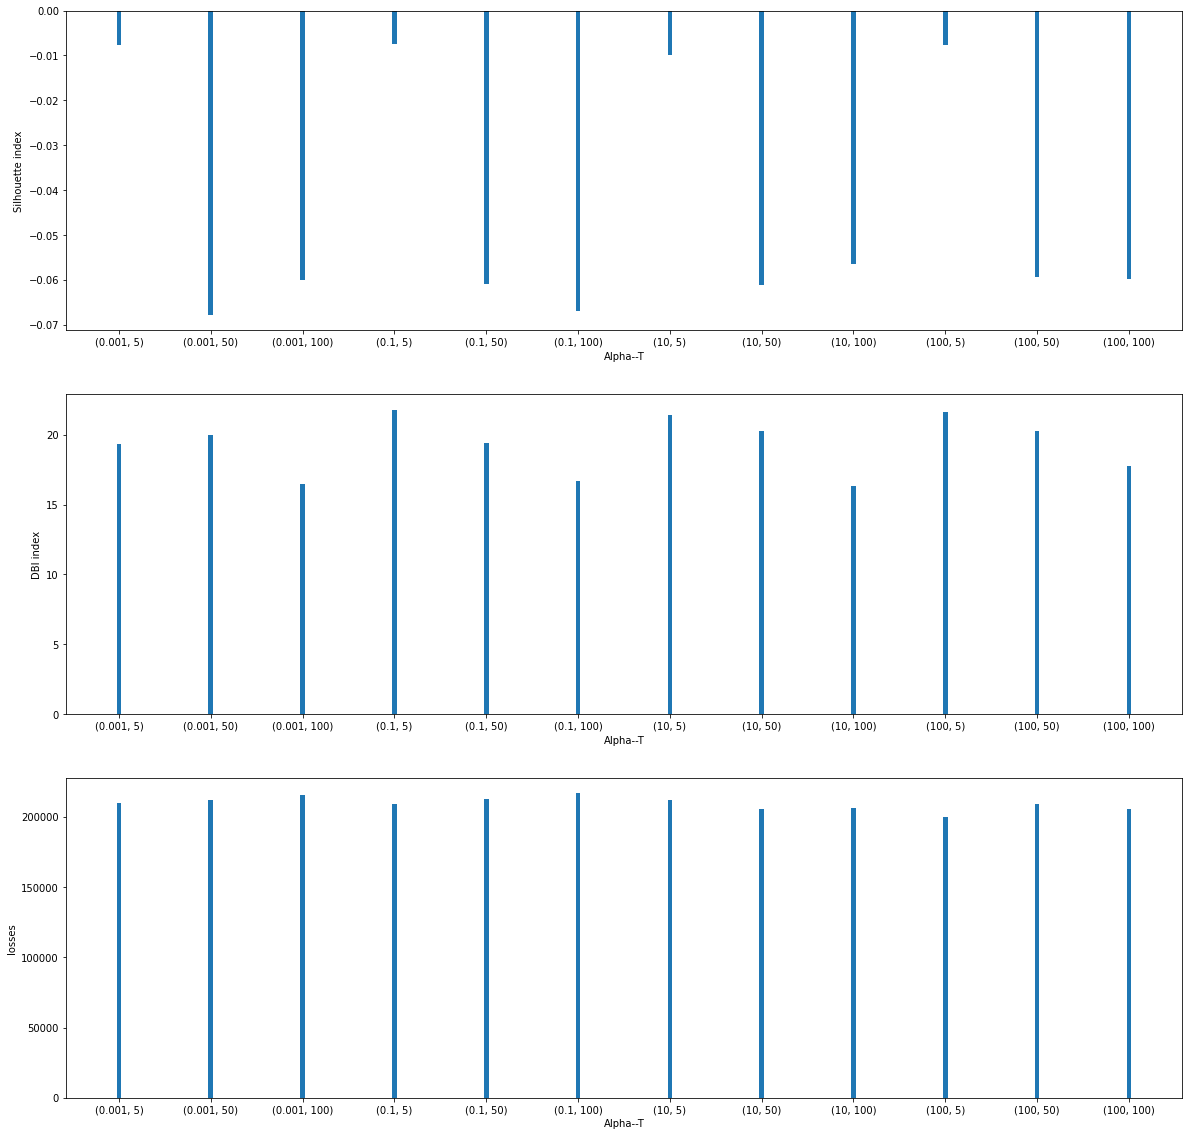

In [12]:
fig, axx = plt.subplots(3, 1, figsize=(20,20))
indx = 0
x_axis = list(map(str,params_tuples))
axx[indx].bar(x_axis, silhouette_array, width=0.05)
axx[indx].set_xlabel("Alpha--T", size = 10)
axx[indx].set_ylabel("Silhouette index", size= 10)

indx = 1
axx[indx].bar(x_axis, dbi_array, width=0.05)
axx[indx].set_xlabel("Alpha--T", size = 10)
axx[indx].set_ylabel("DBI index", size= 10)

indx = 2
axx[indx].bar(x_axis, losses_array, width=0.05)
axx[indx].set_xlabel("Alpha--T", size = 10)
axx[indx].set_ylabel("losses", size= 10)
